<a href="https://colab.research.google.com/github/maoramirez69/14MBID/blob/main/1_Modelo_Chagas_LmABCB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# instalar versión específica de itsdangerous para evitar conflictos
!pip install -U itsdangerous
#!pip install itsdangerous#==2.1.2
!pip install chembl_webresource_client

## Importar las Librerías

In [ ]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
import numpy as np
import seaborn as sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings 
import re
import io
import matplotlib.cm as cm
from numpy import corrcoef, transpose, arange
from pylab import pcolor, show, colorbar, xticks, yticks
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from numpy import corrcoef, transpose, arange
from IPython.display import Image
import statsmodels.api as sm
from scipy import stats
import matplotlib as mpl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
#from google.colab import data_table
#data_table.disable_dataframe_formatter()

## **Base a utilizar: ChEMBL**
Se utilizarán datos recuperados de la base de datos ChEMBL. Para más información ver [*Base de Datos de ChEMBL*](https://www.ebi.ac.uk/chembl/)

Se busca en objetivos o 'targets' la primera enfermedad, en este caso será chagas desde ChEMBL [*Query chagas desde ChEMBL*](https://www.ebi.ac.uk/chembl/g/#search_results/targets/query=lymphoma)


In [ ]:
chagas_trg = new_client.target
chagas_trgt_query = chagas_trg.search('trypanosoma')
# Convertir a dataframe
chagas_trgs = pd.DataFrame.from_dict(chagas_trgt_query)
#Visualizar el dataframe
chagas_trgs

In [ ]:
#Calcular el tamaño del dataframe
print('Total registros: ', chagas_trgs.size, ' Dimension: ', chagas_trgs.shape)

Se asigna la tercera entrada (que corresponde a la enfermedad objetivo) a la variable ***selected_target***, probando las 2 primeras entradas sin resultado asociados

In [ ]:
chembl_trg = chagas_trgs.target_chembl_id[2]  #chagas_trgs.target_chembl_id[5]
chembl_trg

Es necesario filtrar la información para que solo recupere datos con bioactividad IC50 para la primera enfermedad **target_chembl_id = 'CHEMBL368'** que se muestran como valor de pChEMBL con valores de IC50

In [ ]:
activity = new_client.activity
res_ic50 = activity.filter(target_chembl_id = chembl_trg).filter(standard_type="IC50")

Se convierte el array **res_ic50** resultado del comando anterior  en *DataFrame* de Pandas.

In [ ]:
df = pd.DataFrame.from_dict(res_ic50) #20 mins

In [ ]:
df = pd.read_csv('chagas_res_1.csv', sep = ',')
df.shape

(14466, 45)

In [ ]:
df['standard_value']
#molecule_chembl_id	canonical_smiles	standard_value

0        70000.0
1            NaN
2        70000.0
3        65800.0
4        70000.0
          ...   
14461     9100.0
14462    22400.0
14463     1200.0
14464      400.0
14465     5400.0
Name: standard_value, Length: 14466, dtype: float64

In [ ]:
#eliminar variables tipo objeto con for excepto molecule_chembl_id y canonical_smiles
for col in df.columns:
    if df[col].dtype == 'object':
        if col != 'molecule_chembl_id' and col != 'canonical_smiles':
            df.drop(col, axis=1, inplace=True)

## Crear mapa de calor

In [ ]:
# crear matriz de correlación
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()
#ver figura generada


<class 'ValueError'>: could not convert string to float: 'CCCCCC(P(=O)(O)O)P(=O)(O)O'

## **Proceso KDD**
Se eliminan registros vacíos en la columna **standard_value** y **canonical_smiles**.

In [ ]:
df = df[df.standard_value.notna()]
df = df[df.canonical_smiles.notna()]
df.shape

(13617, 20)

Se verifica la cantidad de registros únicos y luego se eliminan los duplicados

In [ ]:
len(df.canonical_smiles.unique())
df2_kdd = df.drop_duplicates(['canonical_smiles'])
df2_kdd

,activity_id,assay_variant_accession,assay_variant_mutation,canonical_smiles,document_year,ligand_efficiency,molecule_chembl_id,pchembl_value,potential_duplicate,record_id,src_id,standard_flag,standard_text_value,standard_upper_value,standard_value,target_tax_id,text_value,toid,upper_value,value
0,149705,NaN,NaN,CCCCCC(P(=O)(O)O)P(=O)(O)O,2003.0,NaN,CHEMBL280463,NaN,0,207032,1,1,NaN,NaN,70000.0,5693,NaN,NaN,NaN,70.0
2,150914,NaN,NaN,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,2003.0,NaN,CHEMBL110971,NaN,0,207043,1,1,NaN,NaN,70000.0,5693,NaN,NaN,NaN,70.0
4,150917,NaN,NaN,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,2003.0,NaN,CHEMBL109374,NaN,0,207027,1,1,NaN,NaN,70000.0,5693,NaN,NaN,NaN,70.0
6,154598,NaN,NaN,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,2003.0,NaN,CHEMBL109948,NaN,0,207029,1,1,NaN,NaN,50000.0,5693,NaN,NaN,NaN,50.0
8,155815,NaN,NaN,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,2003.0,NaN,CHEMBL111392,NaN,0,207037,1,1,NaN,NaN,70000.0,5693,NaN,NaN,NaN,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14447,23295790,NaN,NaN,O=C(CCn1ccnc1)c1ccc(Cl)c(F)c1,2021.0,NaN,CHEMBL4854457,4.63,0,3625031,1,1,NaN,NaN,23300.0,5693,NaN,NaN,NaN,23.3
14448,23295791,NaN,NaN,O=C(CCn1ccnc1)c1ccc(F)c2ccccc12,2021.0,NaN,CHEMBL4867967,5.13,0,3625032,1,1,NaN,NaN,7400.0,5693,NaN,NaN,NaN,7.4
14449,23295792,NaN,NaN,COc1cc(OC)cc(C(=O)CCn2cnc3ccccc32)c1,2021.0,NaN,CHEMBL4863983,4.96,0,3625033,1,1,NaN,NaN,11100.0,5693,NaN,NaN,NaN,11.1
14450,23295793,NaN,NaN,O=C(CCn1cnc2ccccc21)C12CC3CC(CC(C3)C1)C2,2021.0,NaN,CHEMBL4866134,4.61,0,3625034,1,1,NaN,NaN,24800.0,5693,NaN,NaN,NaN,24.8


## Eliminar variables que no aportan al modelo

In [ ]:
# dejar solo las variables molecule_chembl_id canonical_smiles y standard_value
df2_kdd = df2_kdd[['molecule_chembl_id', 'canonical_smiles', 'standard_value']]
df2_kdd

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL280463,CCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0
2,CHEMBL110971,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,70000.0
4,CHEMBL109374,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,70000.0
6,CHEMBL109948,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,50000.0
8,CHEMBL111392,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0
...,...,...,...
14447,CHEMBL4854457,O=C(CCn1ccnc1)c1ccc(Cl)c(F)c1,23300.0
14448,CHEMBL4867967,O=C(CCn1ccnc1)c1ccc(F)c2ccccc12,7400.0
14449,CHEMBL4863983,COc1cc(OC)cc(C(=O)CCn2cnc3ccccc32)c1,11100.0
14450,CHEMBL4866134,O=C(CCn1cnc2ccccc21)C12CC3CC(CC(C3)C1)C2,24800.0


In [ ]:
#imputar valores faltantes en standard_value con valor minimo
df2_kdd['standard_value'] = df2_kdd['standard_value'].fillna(df2_kdd['standard_value'].min())
df2_kdd

C:/Users/LEGION/AppData/Local/Temp/xpython_17204/2249629564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_kdd['standard_value'] = df2_kdd['standard_value'].fillna(df2_kdd['standard_value'].min())


,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL280463,CCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0
2,CHEMBL110971,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,70000.0
4,CHEMBL109374,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,70000.0
6,CHEMBL109948,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,50000.0
8,CHEMBL111392,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0
...,...,...,...
14447,CHEMBL4854457,O=C(CCn1ccnc1)c1ccc(Cl)c(F)c1,23300.0
14448,CHEMBL4867967,O=C(CCn1ccnc1)c1ccc(F)c2ccccc12,7400.0
14449,CHEMBL4863983,COc1cc(OC)cc(C(=O)CCn2cnc3ccccc32)c1,11100.0
14450,CHEMBL4866134,O=C(CCn1cnc2ccccc21)C12CC3CC(CC(C3)C1)C2,24800.0


In [ ]:
# crear expresión regular para validar smiles
pattern = re.compile('^(?:\[.*?\]|[A-Za-z0-9@%+\-=\(\)\[\]\{\}\.\#\$\*\^\~\?\!\/\\\:]+)$')
# crear función para validar smiles
def valid_smiles(smiles):
    if pattern.match(smiles):
        return True
    else:
        return False
    
# crear nueva columna con resultado de validación
df2_kdd['is_valid'] = df2_kdd['canonical_smiles'].apply(valid_smiles)

C:/Users/LEGION/AppData/Local/Temp/xpython_17204/3281466454.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_kdd['is_valid'] = df2_kdd['canonical_smiles'].apply(valid_smiles)


In [ ]:
df2_kdd.head(3)

,molecule_chembl_id,canonical_smiles,standard_value,is_valid
0,CHEMBL280463,CCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0,True
2,CHEMBL110971,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,70000.0,True
4,CHEMBL109374,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,70000.0,True


In [ ]:
#eliminar registros con smiles no validos
df2_kdd = df2_kdd[df2_kdd.is_valid == True]
df2_kdd

,molecule_chembl_id,canonical_smiles,standard_value,is_valid
0,CHEMBL280463,CCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0,True
2,CHEMBL110971,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,70000.0,True
4,CHEMBL109374,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,70000.0,True
6,CHEMBL109948,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,50000.0,True
8,CHEMBL111392,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0,True
...,...,...,...,...
14447,CHEMBL4854457,O=C(CCn1ccnc1)c1ccc(Cl)c(F)c1,23300.0,True
14448,CHEMBL4867967,O=C(CCn1ccnc1)c1ccc(F)c2ccccc12,7400.0,True
14449,CHEMBL4863983,COc1cc(OC)cc(C(=O)CCn2cnc3ccccc32)c1,11100.0,True
14450,CHEMBL4866134,O=C(CCn1cnc2ccccc21)C12CC3CC(CC(C3)C1)C2,24800.0,True


Ejemplo de verificación de diagrama de la segunda molécula

In [ ]:
#!pip install rdkit
from rdkit import Chem
molecula_0 = Chem.MolFromSmiles(df2_kdd['canonical_smiles'][0])

CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O


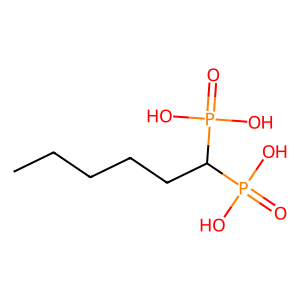

In [ ]:
print(df2_kdd['canonical_smiles'][2])
#dibujar molecula .png
from rdkit.Chem import Draw
Draw.MolToFile(molecula_0, 'molecula_0.png')
#guardar molecula .png
from IPython.display import Image
Image(filename='molecula_0.png')

## Resetear índices

In [ ]:
df2_kdd = df2_kdd.reset_index()
df2_kdd.to_csv('chagas_02_bioactivity_data_preprocessed.csv', index=False)

### **Categorizar compuestos**
Los datos de bioactividad, consignados en la columna standard_value, están en unidades de IC50. Se clasifican estos valores en tres categorías. Los compuestos que tengan valores inferiores a 1.000 nM se considerarán **‘activos’**, Los valores entre 1.000 nM y 10.000 nM tendrán una categoría **‘NaN’** debido a que no se utilizarán, mientras que los valores superiores a 10.000 nM se considerarán **‘inactivos**’.

In [ ]:
import numpy as np

df2_kdd['valor_bioactividad'] = ''
df2_kdd['valor_bioactividad'] = np.where(df2_kdd['standard_value'] >= 10000, 'inactivo', np.where(df2_kdd['standard_value'] <= 1000, 'activo','NA' ))
df2_kdd = df2_kdd[(df2_kdd.valor_bioactividad == 'activo') | (df2_kdd.valor_bioactividad == 'inactivo')]
#reemplazar ceros con valor más pequeño
df2_kdd['standard_value'] = df2_kdd['standard_value'].replace(0.0, 0.06)
df2_kdd = df2_kdd.reset_index()
df2_kdd
#df4.drop(columns=['rango'])

,level_0,index,molecule_chembl_id,canonical_smiles,standard_value,is_valid,valor_bioactividad
0,0,0,CHEMBL280463,CCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0,True,inactivo
1,1,2,CHEMBL110971,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,70000.0,True,inactivo
2,2,4,CHEMBL109374,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,70000.0,True,inactivo
3,3,6,CHEMBL109948,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,50000.0,True,inactivo
4,4,8,CHEMBL111392,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0,True,inactivo
...,...,...,...,...,...,...,...
7044,8707,14445,CHEMBL4878985,Cc1ccccc1C(=O)CCn1ccnc1,21400.0,True,inactivo
7045,8708,14446,CHEMBL4853502,O=C(CCn1ccnc1)c1cccc([N+](=O)[O-])c1,21600.0,True,inactivo
7046,8709,14447,CHEMBL4854457,O=C(CCn1ccnc1)c1ccc(Cl)c(F)c1,23300.0,True,inactivo
7047,8711,14449,CHEMBL4863983,COc1cc(OC)cc(C(=O)CCn2cnc3ccccc32)c1,11100.0,True,inactivo


In [ ]:
#eliminar columna index y is_valid
df2_kdd = df2_kdd.drop(columns=['index', 'is_valid'])

In [ ]:
df2_kdd

,level_0,molecule_chembl_id,canonical_smiles,standard_value,valor_bioactividad
0,0,CHEMBL280463,CCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0,inactivo
1,1,CHEMBL110971,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,70000.0,inactivo
2,2,CHEMBL109374,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,70000.0,inactivo
3,3,CHEMBL109948,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,50000.0,inactivo
4,4,CHEMBL111392,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,70000.0,inactivo
...,...,...,...,...,...
7044,8707,CHEMBL4878985,Cc1ccccc1C(=O)CCn1ccnc1,21400.0,inactivo
7045,8708,CHEMBL4853502,O=C(CCn1ccnc1)c1cccc([N+](=O)[O-])c1,21600.0,inactivo
7046,8709,CHEMBL4854457,O=C(CCn1ccnc1)c1ccc(Cl)c(F)c1,23300.0,inactivo
7047,8711,CHEMBL4863983,COc1cc(OC)cc(C(=O)CCn2cnc3ccccc32)c1,11100.0,inactivo


## PARTE 2: **Instalación de conda**

In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
!bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
!conda install -c rdkit rdkit -y
import sys

Eliminar columna *canonical_smiles* separando dos datasets

In [ ]:
df_no_smiles = df2_kdd.drop(columns='canonical_smiles')

smiles = []

for i in df2_kdd.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

In [ ]:
# segundo dataframe
df_clean_smiles = pd.concat([df_no_smiles, smiles], axis=1)
df_clean_smiles

,level_0,molecule_chembl_id,standard_value,valor_bioactividad,canonical_smiles
0,0,CHEMBL280463,70000.0,inactivo,CCCCCC(P(=O)(O)O)P(=O)(O)O
1,1,CHEMBL110971,70000.0,inactivo,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O
2,2,CHEMBL109374,70000.0,inactivo,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC
3,3,CHEMBL109948,50000.0,inactivo,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC
4,4,CHEMBL111392,70000.0,inactivo,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O
...,...,...,...,...,...
7044,8707,CHEMBL4878985,21400.0,inactivo,Cc1ccccc1C(=O)CCn1ccnc1
7045,8708,CHEMBL4853502,21600.0,inactivo,O=C(CCn1ccnc1)c1cccc([N+](=O)[O-])c1
7046,8709,CHEMBL4854457,23300.0,inactivo,O=C(CCn1ccnc1)c1ccc(Cl)c(F)c1
7047,8711,CHEMBL4863983,11100.0,inactivo,COc1cc(OC)cc(C(=O)CCn2cnc3ccccc32)c1


## **Calcular descriptores de Lipinski**
Christopher Lipinski, un científico de Pfizer, ideó un conjunto de reglas empíricas para evaluar la similitud de los compuestos con las drogas. Tal semejanza con las drogas se basa en la Absorción, Distribución, Metabolismo y Excreción (ADME), que también se conoce como perfil farmacocinético. Lipinski analizó todos los medicamentos activos por vía oral aprobados por la FDA en la formulación de lo que se conocerá como la regla de los cinco o la regla de Lipinski.

La Regla de Lipinski establecía lo siguiente:

Peso molecular < 500 Dalton
Coeficiente de reparto octanol-agua (LogP) < 5
Donantes de enlaces de hidrógeno < 5
Aceptores de enlaces de hidrógeno < 10

In [ ]:
"""
Lipinski:
    Peso Molecular          <= 500
    LogP                    <= 5
    Donadores de Hidrógeno  <= 5
    Aceptores de Hidrógeno  <= 10
"""
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [ ]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["Peso_Molecular","LogP","Num_Donadores_H","Num_Aceptores"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

df_lipinski = lipinski(df2_kdd.canonical_smiles)
#convertir Num_Donadores_H y Num_Aceptores a enteros
df_lipinski[['Num_Donadores_H', 'Num_Aceptores']] = df_lipinski[['Num_Donadores_H', 'Num_Aceptores']].astype(int)
df_lipinski

,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores
0,246.136,1.24820,4,2
1,304.216,1.73850,5,3
2,330.298,4.64480,0,6
3,386.406,6.20520,0,6
4,302.244,2.80860,4,2
...,...,...,...,...
7044,214.268,2.46452,0,3
7045,245.238,2.06430,0,5
7046,252.676,2.94860,0,3
7047,310.353,3.32650,0,5


### **Unión de datasets**
Se unen los datasets

In [ ]:
df_combined = pd.concat([df_clean_smiles ,df_lipinski], axis=1)
df_combined

,level_0,molecule_chembl_id,standard_value,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores
0,0,CHEMBL280463,70000.0,inactivo,CCCCCC(P(=O)(O)O)P(=O)(O)O,246.136,1.24820,4,2
1,1,CHEMBL110971,70000.0,inactivo,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,304.216,1.73850,5,3
2,2,CHEMBL109374,70000.0,inactivo,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,330.298,4.64480,0,6
3,3,CHEMBL109948,50000.0,inactivo,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,386.406,6.20520,0,6
4,4,CHEMBL111392,70000.0,inactivo,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,302.244,2.80860,4,2
...,...,...,...,...,...,...,...,...,...
7044,8707,CHEMBL4878985,21400.0,inactivo,Cc1ccccc1C(=O)CCn1ccnc1,214.268,2.46452,0,3
7045,8708,CHEMBL4853502,21600.0,inactivo,O=C(CCn1ccnc1)c1cccc([N+](=O)[O-])c1,245.238,2.06430,0,5
7046,8709,CHEMBL4854457,23300.0,inactivo,O=C(CCn1ccnc1)c1ccc(Cl)c(F)c1,252.676,2.94860,0,3
7047,8711,CHEMBL4863983,11100.0,inactivo,COc1cc(OC)cc(C(=O)CCn2cnc3ccccc32)c1,310.353,3.32650,0,5


### **Convertir IC50 a pIC50**
Para permitir que los datos de **IC50** se distribuyan de manera más uniforme, convertiremos **IC50** a la escala logarítmica negativa que es esencialmente **-log10(IC50)**.

Esta función pIC50() recibe el dataset como parámetro de entrada.
* Toma el valor de IC50 desde la columna ``standard_value`` y la convierte desde nM a M y luego multiplica el valor por 10$^{-9}$
* Toma el valor molar y luego aplica el -log10
* Se borra la columna ``standard_value`` y se reemplaza por la columna ``pIC50``

In [ ]:
df_combined.standard_value.describe()

count    7.049000e+03
mean     8.031167e+04
std      4.356837e+05
min      5.700000e-02
25%      1.000000e+02
50%      1.510000e+04
75%      5.011872e+04
max      1.740700e+07
Name: standard_value, dtype: float64

In [ ]:
#Los valores superiores a 100 000 000 se fijarán en 100 000 000; de lo contrario, el valor logarítmico negativo se volverá negativo.
-np.log10( (10**-9)* 100000000 )
-np.log10( (10**-9)* 100000000 )

1.0

In [ ]:
def normalizar_pic50(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_pic50'] = norm
    x = input.drop('standard_value', 1)
        
    return x

df_pic50 = normalizar_pic50(df_combined)
df_pic50

<class 'TypeError'>: DataFrame.drop() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_pic50']:
        molar = i*(10**-9)
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_pic50', 1)
        
    return x

df_final = pIC50(df_pic50)
df_final

<class 'NameError'>: name 'df_pic50' is not defined

In [ ]:
#df_final.to_csv('chagas_04_bioactivity_data_3class_pIC50.csv')

df_final = pd.read_csv('chagas_04_bioactivity_data_3class_pIC50.csv')

### **Eliminar valores NaN de la columna valor_bioactividad**
Aquí, eliminaremos el valor ``NaN`` de nuestro conjunto de datos.

In [ ]:
df2 = df_final.dropna()
df2.reset_index()
df2
#df2.to_csv('chagas_05_bioactivity_data_2class_pIC50.csv')

,Unnamed: 0,molecule_chembl_id,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores,pIC50
0,0,CHEMBL280463,inactivo,CCCCCC(P(=O)(O)O)P(=O)(O)O,246.136,1.24820,4,2,4.154902
1,1,CHEMBL110971,inactivo,CCCCCCCCC(O)(P(=O)(O)O)P(=O)(O)O,304.216,1.73850,5,3,4.154902
2,2,CHEMBL109374,inactivo,CCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,330.298,4.64480,0,6,4.154902
3,3,CHEMBL109948,inactivo,CCCCCCCC(P(=O)(OCC)OCC)P(=O)(OCC)OCC,386.406,6.20520,0,6,4.301030
4,4,CHEMBL111392,inactivo,CCCCCCCCCC(P(=O)(O)O)P(=O)(O)O,302.244,2.80860,4,2,4.154902
...,...,...,...,...,...,...,...,...,...
7044,7044,CHEMBL4878985,inactivo,Cc1ccccc1C(=O)CCn1ccnc1,214.268,2.46452,0,3,4.669586
7045,7045,CHEMBL4853502,inactivo,O=C(CCn1ccnc1)c1cccc([N+](=O)[O-])c1,245.238,2.06430,0,5,4.665546
7046,7046,CHEMBL4854457,inactivo,O=C(CCn1ccnc1)c1ccc(Cl)c(F)c1,252.676,2.94860,0,3,4.632644
7047,7047,CHEMBL4863983,inactivo,COc1cc(OC)cc(C(=O)CCn2cnc3ccccc32)c1,310.353,3.32650,0,5,4.954677


In [ ]:
#leer csv
import pandas as pd
from pandas import read_csv
#df2 = read_csv('chagas_05_bioactivity_data_2class_pIC50.csv', sep=',')

## **Análisis de datos exploratorios (Análisis del espacio químico) a través del descriptor de Lipinski**

In [ ]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt


### **Diagrama de frecuencias para las dos categorías**
#dibujar grafica .png
plt.figure(figsize=(6, 6))
#calbiar colores de barras a morado y amarillo
sns.countplot(x='valor_bioactividad', data=df2, edgecolor='blue') #facecolor='blue'
#sns.countplot(x='valor_bioactividad', data=df2, palette = 'hls', edgecolor = 'black')
plt.xlabel('Categorías_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('Frecuencia', fontsize=14, fontweight='bold')
#cambiar colores de la grafica
sns.set_palette("pastel")

In [ ]:
#Se construye un pie chart para visualizar la distribución de las dos clases
plt.figure(figsize=(6,6))
#se cambia el color de las barras a morado y amarillo
sns.set_palette("pastel")
#se dibuja el pie chart
df2.valor_bioactividad.value_counts().plot.pie(autopct='%1.1f%%', shadow=False, explode=(0.0,0), startangle=90)
#rotar el pie chart 10 grados
plt.xticks(rotation=90)
#contorno de la grafica azul
plt.rcParams['patch.edgecolor'] = 'blue'
plt.ylabel('Categorías_Bioactividad', fontsize=14, fontweight='bold')
# plt.savefig('pie_chart_categorias_bioactividad.png')
# #guardar pie chart .png
# Image(filename='pie_chart_categorias_bioactividad.png')

Text(0, 0.5, 'Categorías_Bioactividad')

In [ ]:
#equilibrar las clases
df2.valor_bioactividad.value_counts()

#seleccionar las clases con 2500 elementos aleatorios
df2_activo = df2[df2.valor_bioactividad == 'activo'].sample(2500)
df2_inactivo = df2[df2.valor_bioactividad == 'inactivo'].sample(2500)

#concatenar los dos dataframes
df2 = pd.concat([df2_activo, df2_inactivo], axis=0)
df2 = df2.reset_index(drop=True)
df2

,molecule_chembl_id,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores,pIC50
0,CHEMBL1836005,activo,O=[N+]([O-])c1cn2c(n1)OCC(Oc1ccc(OC(F)(F)F)cc1)C2,345.233,2.52990,0,7,6.408935
1,CHEMBL4074666,activo,CC1(COc2ccc(-c3ccc(OC(F)(F)F)cc3)cc2)Cn2cc([N+...,451.426,5.30030,0,7,7.070581
2,CHEMBL1725748,activo,Cc1cc(C)c(C#N)c(SCC(=O)c2ccc3c(c2)OCO3)n1,326.377,3.27382,0,6,6.399997
3,CHEMBL3628932,activo,CCCCC(C(=O)COc1c(F)c(F)cc(F)c1F)n1cc([C@@](C)(...,521.559,5.26990,1,7,6.844664
4,CHEMBL1863161,activo,N#Cc1ccnc(N2CCC(NC(c3ccc(C(F)(F)F)cc3)c3cccnc3...,438.457,4.11008,1,6,7.508638
...,...,...,...,...,...,...,...,...
4995,CHEMBL1688568,inactivo,CC(C)(C)OC(=O)NCCCNC1CCN(CCc2ccccc2)CC1,361.530,3.19790,2,4,4.256725
4996,CHEMBL1928244,inactivo,c1ccc2[nH]c(-c3ccc(OCOc4ccc(-c5nc6ccccc6[nH]5)...,432.483,6.18850,2,4,4.948462
4997,CHEMBL3577779,inactivo,C=CCc1ccc(Oc2cc(CC=C)cc(OC)c2OC)c(OC)c1,340.419,4.96170,0,4,4.522879
4998,CHEMBL1275822,inactivo,CC1=N[C@H](C)Cc2c(-c3ccc(C)cc3)ccc(O)c21,265.356,4.12122,1,2,4.405166


### **Diagrama de puntos Peso_Molecular vs LogP**
Puede verse que las 2 categorías de bioactividad abarcan espacios químicos similares, como lo demuestra el diagrama de dispersión de Peso_Molecular frente a LogP.

In [ ]:
plt.figure(figsize=(15, 5.5))
sns.scatterplot(x='Peso_Molecular', y='LogP', data=df2, hue='valor_bioactividad', size='pIC50', edgecolor='black', alpha=0.6, facecolor = 'red')
plt.xlabel('Peso_Molecular', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
# plt.savefig('plot_Peso_Molecular_vs_LogP.png')
# #guardar gráfica .png
# Image(filename='plot_Peso_Molecular_vs_LogP.png')

In [ ]:
sb.pairplot(df2.dropna(),hue='valor_bioactividad',size=4,vars=["LogP","Peso_Molecular"],kind="scatter")
#guardar gráfica .png
# plt.savefig('plot_Peso_Molecular_vs_LogP_1.png')
# Image(filename='plot_Peso_Molecular_vs_LogP_1.png')

c:\Python3\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\Python3\lib\site-packages\seaborn\axisgrid.py:1242: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


<class 'pandas._config.config.OptionError'>: No such keys(s): 'mode.use_inf_as_null'

### **Box plots**
#### **PIC50**

In [ ]:
# crear dos dataframes, uno para cada clase
df_2_activo = df2[df2['valor_bioactividad']=='activo']
df_2_inactivo = df2[df2['valor_bioactividad']=='inactivo']

In [ ]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'valor_bioactividad', y = 'pIC50', data = df2)
plt.xlabel('Categorías_Bioactividad', fontsize=14, fontweight='bold', )
plt.ylabel('valor_PIC50', fontsize=14, fontweight='bold')
# plt.savefig('plot_ic50.png')
# Image(filename='plot_ic50.png')

Text(0, 0.5, 'valor_PIC50')

In [ ]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'valor_bioactividad', y = 'Peso_Molecular', data = df2)
plt.xlabel('Categorías_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('Peso_Molecular', fontsize=14, fontweight='bold')
# plt.savefig('plot_MW.png')
# Image(filename='plot_MW.png')

Text(0, 0.5, 'Peso_Molecular')

In [ ]:
n_bins = 8
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#gráfica del histograma usuarios activos
axs[0].hist(df_2_activo['Peso_Molecular'], bins=n_bins)
#gráfica del histograma usuarios inactivos
axs[1].hist(df_2_inactivo['Peso_Molecular'], bins=n_bins,color='green')
plt.title('histogramas para la clase inactivo y activo', loc='center')
# plt.savefig('histograma.png')
# Image(filename='histograma.png')

Text(0.5, 1.0, 'histogramas para la clase inactivo y activo')

#### **LogP**

In [ ]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'valor_bioactividad', y = 'LogP', data = df2)
plt.xlabel('Categorías_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
# plt.savefig('plot_LogP.png')
# Image(filename='plot_LogP.png')

Text(0, 0.5, 'LogP')

In [ ]:
n_bins = 8
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#gráfica del histograma usuarios activos
axs[0].hist(df_2_activo['LogP'], bins=n_bins)
#gráfica del histograma usuarios inactivos
axs[1].hist(df_2_inactivo['LogP'], bins=n_bins,color='green')
plt.title('histogramas para la clase inactivo y activo')
# plt.savefig('plot_LogP.png')
# Image(filename='plot_LogP.png')

Text(0.5, 1.0, 'histogramas para la clase inactivo y activo')

#### **Num_Donadores_Hidrógeno**

In [ ]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'valor_bioactividad', y = 'Num_Donadores_H', data = df2)
plt.xlabel('Categoría_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('Num_Donadores_Hidrógeno', fontsize=14, fontweight='bold')
# plt.savefig('plot_NumHDonors.png')
# Image(filename='plot_NumHDonors.png')

Text(0, 0.5, 'Num_Donadores_Hidrógeno')

In [ ]:
n_bins = 8
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#gráfica del histograma usuarios activos
axs[0].hist(df_2_activo['Num_Donadores_H'], bins=n_bins)
#gráfica del histograma usuarios inactivos
axs[1].hist(df_2_inactivo['Num_Donadores_H'], bins=n_bins,color='green')
# plt.savefig('plot_NumHDonors.png')
# Image(filename='plot_NumHDonors.png')

(array([2.097e+03, 2.540e+02, 1.290e+02, 9.000e+00, 6.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00]),
 array([ 0.   ,  2.125,  4.25 ,  6.375,  8.5  , 10.625, 12.75 , 14.875,
        17.   ]),
 <BarContainer object of 8 artists>)

#### **Num_Aceptores**

In [ ]:
plt.figure(figsize=(5.5, 5.5))
sns.boxplot(x = 'valor_bioactividad', y = 'Num_Aceptores', data = df2)
plt.xlabel('Categoría_Bioactividad', fontsize=14, fontweight='bold')
plt.ylabel('Numero_Aceptores_Hidrógeno', fontsize=14, fontweight='bold')
# plt.savefig('plot_NumHAcceptors.png')
# Image(filename='plot_NumHAcceptors.png')

Text(0, 0.5, 'Numero_Aceptores_Hidrógeno')

In [ ]:
n_bins = 8
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
#gráfica del histograma usuarios activos
axs[0].hist(df_2_activo['Num_Aceptores'], bins=n_bins)
#gráfica del histograma usuarios inactivos
axs[1].hist(df_2_inactivo['Num_Aceptores'], bins=n_bins,color='green')
plt.title('histogramas para la clase inactivo y activo')
# plt.savefig('plot_NumHAcceptors.png')
# Image(filename='plot_NumHAcceptors.png')

Text(0.5, 1.0, 'histogramas para la clase inactivo y activo')

## ???????

In [ ]:
from rdkit.Chem import Descriptors
from rdkit.Chem import MolFromSmiles

mols = []

for i in df2.canonical_smiles:
        mol = MolFromSmiles(i)
        mols.append(mol)
        #print(df2)
ID = df2.molecule_chembl_id
STATUS = df2.valor_bioactividad
MW = [Descriptors.MolWt(n) for n in mols]
LogP = [Descriptors.MolLogP(o) for o in mols]
nHAcc = [Descriptors.NumHAcceptors(p) for p in mols]
nHDon = [Descriptors.NumHDonors(q) for q in mols]

data = pd.DataFrame(
    {'molecule_chembl_id': ID,
     'STATUS' : STATUS,
     'MW': MW, 
     'LogP': LogP,
     'nHAcc': nHAcc,
     'nHDon': nHDon
    })
data = data[['molecule_chembl_id','STATUS','MW','LogP','nHAcc','nHDon']]

In [ ]:
data.shape

(5000, 6)

## Distribución de Frecuencias variables

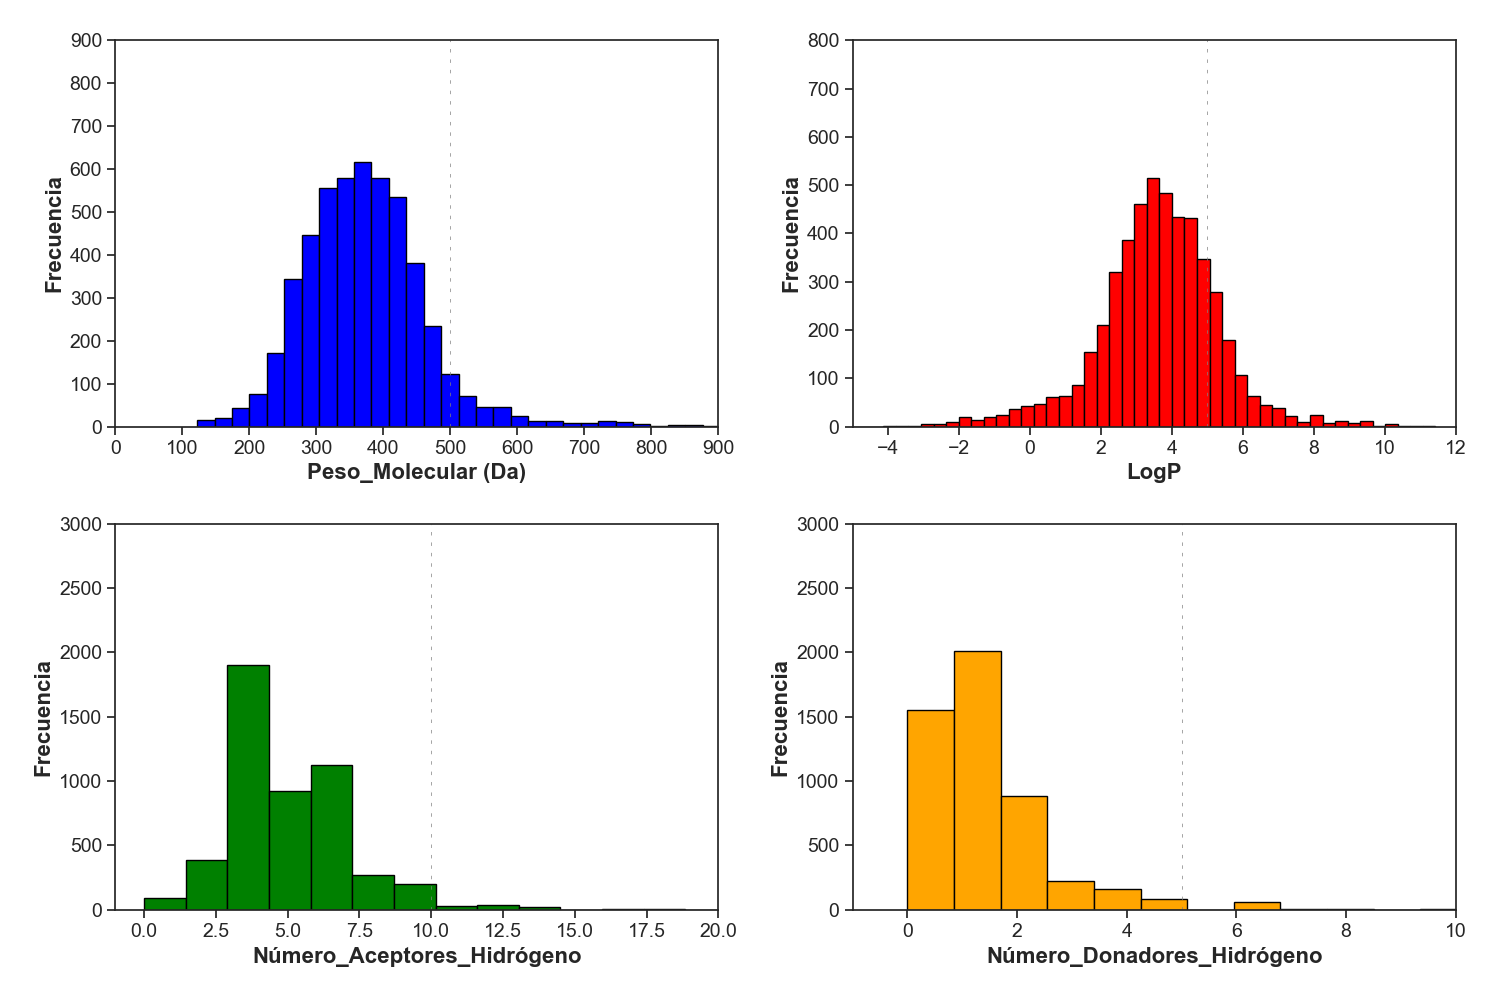

In [ ]:
figure, ((plt1,plt2), (plt3,plt4)) = plt.subplots(2, 2)
figure.set_size_inches(15,10)

# Histograma para MW
hist, bins = np.histogram(MW, 50)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt1.bar(center, hist, align='center', width=width, color='blue',edgecolor='black',\
         error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2,linestyle='-', linewidth=0.5))
plt1.set_xlabel('Peso_Molecular (Da)', fontsize=16, fontweight='bold')
plt1.set_ylabel('Frecuencia', fontsize=16, fontweight='bold')
plt1.tick_params(axis='both', which='major', labelsize=14)
plt1.set_xlim(0,900)
plt1.set_ylim(0, 900)
#plt1.grid(True)
plt1.axvline(500, color='gray',linestyle='--', dashes=(5, 10), linewidth=0.5)

# Histograma para LogP
hist, bins = np.histogram(LogP, 50)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt2.bar(center, hist, align='center', width=width, color='red',edgecolor='black',\
         error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2,linestyle='-', linewidth=0.5))
plt2.set_xlabel('LogP', fontsize=16, fontweight='bold')
plt2.set_ylabel('Frecuencia', fontsize=16, fontweight='bold')
plt2.tick_params(axis='both', which='major', labelsize=14)
plt2.set_xlim(-5,12)
plt2.set_ylim(0,800)
plt2.axvline(5, color='gray',linestyle='--', dashes=(5, 10), linewidth=0.5)

# Histograma para Donadores de Hidrógeno
hist, bins = np.histogram(nHDon, 20)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt4.bar(center, hist, align='center', width=width, color='orange',edgecolor='black',\
         error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2, linestyle='-', linewidth=0.5))
plt4.set_xlabel('Número_Donadores_Hidrógeno', fontsize=16, fontweight='bold')
plt4.set_ylabel('Frecuencia', fontsize=16, fontweight='bold')
plt4.tick_params(axis='both', which='major', labelsize=14)
plt4.set_xlim(-1,10)
plt4.set_ylim(0,3000)
#plt4.grid(True)
plt4.axvline(5, color='gray',linestyle='--', dashes=(5, 10), linewidth=0.5)

# Histograma para nHAcc
hist, bins = np.histogram(nHAcc, 20)
width = 1 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt3.bar(center, hist, align='center', width=width, color='green',edgecolor='black',\
         error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2, linestyle='-', linewidth=0.5))
plt3.set_xlabel('Número_Aceptores_Hidrógeno', fontsize=16, fontweight='bold')
plt3.set_ylabel('Frecuencia', fontsize=16, fontweight='bold')
plt3.tick_params(axis='both', which='major', labelsize=14)
plt3.set_xlim(-1,20)
plt3.set_ylim(0,3000)
#plt3.grid(True)
plt3.axvline(10, color='gray',linestyle='--', dashes=(5, 10), linewidth=0.5)

plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)
plt.savefig('plot_descriptores.png')
Image(filename='plot_descriptores.png')

## ??????

In [ ]:
from rdkit.Chem import Descriptors
from rdkit.Chem import MolFromSmiles

ID = df2.molecule_chembl_id
STATUS = df2.valor_bioactividad

mols = []

for i in df2.canonical_smiles:
        mol = MolFromSmiles(i)
        mols.append(mol)
MW = [Descriptors.MolWt(n) for n in mols]
LogP = [Descriptors.MolLogP(o) for o in mols]
nHAcc = [Descriptors.NumHAcceptors(p) for p in mols]
nHDon = [Descriptors.NumHDonors(q) for q in mols]

print(nHDon)

data = pd.DataFrame(
    {'molecule_chembl_id': ID,
     'valor_bioactividad' : STATUS,
     'Peso_Molecular': MW, 
     'LogP': LogP,
     'Num_Aceptores': nHAcc,
     'Num_Donadores_H': nHDon
    })

[0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 0, 0, 2, 2, 1, 6, 1, 1, 4, 1, 0, 2, 2, 1, 1, 2, 1, 0, 1, 1, 0, 2, 3, 1, 2, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1, 0, 0, 0, 1, 2, 0, 2, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 3, 1, 0, 0, 2, 0, 0, 0, 2, 1, 1, 1, 0, 1, 4, 4, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 2, 2, 1, 4, 1, 0, 2, 0, 1, 0, 2, 1, 2, 1, 0, 1, 1, 0, 2, 1, 0, 1, 0, 1, 3, 1, 2, 2, 5, 0, 1, 4, 4, 0, 1, 0, 0, 4, 1, 1, 0, 2, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 0, 1, 3, 2, 0, 2, 1, 0, 4, 2, 1, 3, 1, 7, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 4, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 3, 0, 0, 2, 2, 0, 1, 1, 0, 4, 1, 1, 0, 0, 0, 1, 2, 1, 0, 1, 0, 1, 1, 0, 1, 2, 1, 2, 1, 1, 0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 2, 1, 2, 1, 3, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 2, 2, 1, 1, 0, 0, 2, 1, 2, 0, 1, 0, 1, 0, 4, 1, 0, 0, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 3, 2, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 0, 2, 0, 1, 0, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 1, 

## Gráficas de densidad para cada medición PIC50 (Estimación Kernel)

In [ ]:
plt.figure()
plt.subplot(2, 1,1)
plt.title('Densidades de PIC50 para cada clase')
ax = sns.distplot(df_2_activo['pIC50'], rug=True, hist=False,label='PIC50 clase activa',color='blue')
plt.legend()
plt.subplot(2, 1,2)
ax = sns.distplot(df_2_inactivo['pIC50'], rug=True, hist=False,label='PIC50 clase inactiva',color='green')
plt.legend()
plt.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)
# plt.savefig('densidad_pic50.png')
# Image(filename='densidad_pic50.png')

c:\Python3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<class 'pandas._config.config.OptionError'>: No such keys(s): 'mode.use_inf_as_null'

## Análisis inferencial
En esta sección se van a analizar inferencialmnete  a la variable *PIC50* para la clase activo e inactivo. Por lo tanto, se cargan las siguientes librerías

In [ ]:
#Se va a construir los QQ-plot para  'PIC50' en cada una de las  clases
#Esto se hace con el objetivo de analizar si los cuantiles teóricos ccoinciden con los cuantiles muestrales 
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(df_2_activo['pIC50'],fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q de PIC50 para la clase activa', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)
plt.tight_layout()
# plt.savefig('qqplot_activo.png')
# Image(filename='qqplot_activo.png')

In [ ]:
#Se va a construir los QQ-plot para  'PIC50' en cada una de las  clases
#Esto se hace con el objetivo de analizar si los cuantiles teóricos ccoinciden con los cuantiles muestrales 
fig, ax = plt.subplots(figsize=(7,4))
sm.qqplot(df_2_inactivo['pIC50'],fit   = True,
    line  = 'q',
    alpha = 0.4,
    lw    = 2,
    ax    = ax
)
ax.set_title('Gráfico Q-Q de PIC50 para la clase inactiva', fontsize = 10,
             fontweight = "bold")
ax.tick_params(labelsize = 7)
plt.tight_layout()
# plt.savefig('qqplot_inactivo.png')
# Image(filename='qqplot_inactivo.png')

Se puede apreciar que  empíricamente los cuantiles muestrales de **PIC50** de la clase **inactiva** no se ajustan bien a los cuantiles teóricos de la distribución normal 

In [ ]:
# Test de Shapiro-Wilk  (clase activa)
# ==============================================================================
shapiro_test = stats.shapiro(df_2_activo['pIC50'])
shapiro_test

ShapiroResult(statistic=0.9628936052322388, pvalue=7.762468714351081e-25)

En este caso el $$p-valor=8.68832989120154*10^{-27}$$ 
Luego, a un nivel de significancia de $$\alpha=0.05$$
Se tiene que: $$p-valor=8.68832989120154*10^{-27}<0.05=\alpha$$
Por lo tanto, se rechaza la hipótesis  nula. Es decir, que como se había apreciada empíricamente la muestra no viene de una población con distribución normal. Por lo tanto, existe evidencia estadística para deducir que la variable **PIC50** de la clase activa no tiene una distribución normal.

In [ ]:
# Test de Shapiro-Wilk  (clase inactiva)
# ==============================================================================
shapiro_test = stats.shapiro(df_2_inactivo['pIC50'])
shapiro_test

ShapiroResult(statistic=0.933936357498169, pvalue=6.161251959573674e-32)

En este caso el $$p-valor=1.5192948015132883*10^{-39}$$ 
Luego, a un nivel de significancia de $$\alpha=0.05$$
Se tiene que: $$p-valor=1.5192948015132883*10^{-39}<0.05=\alpha$$
Por lo tanto, se rechaza la hipótesis  nula. Es decir, que como se había apreciada empíricamente la muestra no viene de una población con distribución normal. Por lo tanto, existe evidencia estadística para deducir que la variable **PIC50** de la clase activa no tiene una distribución normal.

## TEST MANWHITNEY

In [ ]:
def mannwhitney(descriptor, verbose=False):
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# Establecer semilla
  seed(1)

# Activos e inactivos
  selection = [descriptor, 'valor_bioactividad']
  df = df2[selection]
  activo = df[df['valor_bioactividad'] == 'activo']
  activo = activo[descriptor]

  selection = [descriptor, 'valor_bioactividad']
  df = df2[selection]
  inactivo = df[df['valor_bioactividad'] == 'inactivo']
  inactivo = inactivo[descriptor]

# Comparar muestras
  stat, p = mannwhitneyu(activo, inactivo)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpretación de resultados
  alpha = 0.05
  if p > alpha:
    resultado = 'Misma distribución (no rechazar H0)'
  else:
    resultado = 'Diferente distribución (rechazar H0)'
  
  results = pd.DataFrame({'Variable':descriptor,
                          'Resultado':stat,
                          'p-value':p,
                          'alpha':alpha,
                          'Interpretación':resultado}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
mannwhitney('Peso_Molecular')

,Variable,Resultado,p-value,alpha,Interpretación
0,Peso_Molecular,4074806.5,2.643383e-77,0.05,Diferente distribución (rechazar H0)


In [ ]:
mannwhitney('LogP')

,Variable,Resultado,p-value,alpha,Interpretación
0,LogP,3668945.0,1.599559e-26,0.05,Diferente distribución (rechazar H0)


In [ ]:
mannwhitney('Num_Donadores_H')

,Variable,Resultado,p-value,alpha,Interpretación
0,Num_Donadores_H,2916156.0,0.000016,0.05,Diferente distribución (rechazar H0)


In [ ]:
mannwhitney('Num_Aceptores')

,Variable,Resultado,p-value,alpha,Interpretación
0,Num_Aceptores,3320148.0,0.000109,0.05,Diferente distribución (rechazar H0)


In [ ]:
!wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
!wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

In [ ]:
#df3 = pd.read_csv('chagas_04_bioactivity_data_3class_pIC50.csv')
#eliminar columnas con 'Uname: 0'
df3 = df2#.drop(columns=['Unnamed: 0'])
df3.head(3)

,molecule_chembl_id,valor_bioactividad,canonical_smiles,Peso_Molecular,LogP,Num_Donadores_H,Num_Aceptores,pIC50
0,CHEMBL1836005,activo,O=[N+]([O-])c1cn2c(n1)OCC(Oc1ccc(OC(F)(F)F)cc1)C2,345.233,2.52990,0,7,6.408935
1,CHEMBL4074666,activo,CC1(COc2ccc(-c3ccc(OC(F)(F)F)cc3)cc2)Cn2cc([N+...,451.426,5.30030,0,7,7.070581
2,CHEMBL1725748,activo,Cc1cc(C)c(C#N)c(SCC(=O)c2ccc3c(c2)OCO3)n1,326.377,3.27382,0,6,6.399997


In [ ]:
df3.shape

(5000, 8)

In [ ]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
!cat molecule.smi | head -5

"cat" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


## **Calcular fingerprints y descriptores**

In [ ]:
!cat padel.sh

"cat" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [ ]:
! unzip padel.zip

In [ ]:
! bash padel.sh

## **Preparando las Matrices de Datos X e Y**

### **X matriz**

In [ ]:
df3_X = pd.read_csv('descriptors_output.csv')
df3_X = df3_X.drop(columns=['Name'])
df3_X
df3_X.shape

(7049, 881)

## **Y variable**

In [ ]:
df3_Y = df3['pIC50']
df3_Y

0       4.154902
1       4.154902
2       4.154902
3       4.301030
4       4.154902
          ...   
7044    4.669586
7045    4.665546
7046    4.632644
7047    4.954677
7048    4.605548
Name: pIC50, Length: 7049, dtype: float64

## **Unir datasets**

In [ ]:
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3

In [ ]:
# Exportar a .csv
dataset3.to_csv('reutilizacion_06_bioactivity_data_3class_pIC50_pubchem_fp_882.csv', index=False)

#PARTE 4

## **Importar librerías**

## AQUI CHECKPOINT CP

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv('reutilizacion_06_bioactivity_data_3class_pIC50_pubchem_fp_882.csv')
df.shape

(7049, 882)

## **882 Fingerprints para Chagas**

### **Variables de entrada**

In [ ]:
X_882 = df.drop('pIC50', axis=1)
X_882.head(3)

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Y_882 = df.pIC50
Y_882.head(3)

0    4.154902
1    4.154902
2    4.154902
Name: pIC50, dtype: float64

### **Eliminar varianzas muy bajas**

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X_882 = selection.fit_transform(X_882)
#resultado
X_882.shape #Se eliminan 717 variables

(7049, 165)

## **Dividir conjunto de datos en 80% y 20%**

In [ ]:
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train_882, X_test_882, Y_train_882, Y_test_882 = train_test_split(X_882, Y_882, test_size=0.2,random_state=10)
X_train_882.shape, Y_train_882.shape, X_test_882.shape, Y_test_882.shape

((5639, 165), (5639,), (1410, 165), (1410,))

## **Modelo de Regresión Lineal usando Random Forest**

In [ ]:
#model = RandomForestRegressor(n_estimators=100)
import numpy as np
model_RFR = RandomForestRegressor(n_estimators=102, max_depth=16, random_state=0, criterion='squared_error',  min_samples_split=2)
model_RFR.fit(X_train_882, Y_train_882)
r2 = model_RFR.score(X_test_882, Y_test_882)
r2

0.6263890165613613

In [ ]:
#mejorar el modelo con GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

#definir los parámetros
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [8, 10, 12, 14, 16, 18, 20, 22, 24],
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900]
}

#definir el modelo
model_RFR = RandomForestRegressor(random_state=0)

#definir la búsqueda
grid_search = GridSearchCV(estimator = model_RFR, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)

#entrenar el modelo
grid_search.fit(X_train_882, Y_train_882)

#mejores parámetros
grid_search.best_params_

#mejor score
grid_search.best_score_

#mejor modelo
best_grid = grid_search.best_estimator_

Fitting 3 folds for each of 58320 candidates, totalling 174960 fits


: 

: 

In [ ]:
model_RFR.estimators_

[DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=209652396),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=398764591),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=924231285),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=1478610112),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=441365315),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=1537364731),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=192771779),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=1491434855),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=1819583497),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=530702035),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=626610453),
 DecisionTreeRegressor(max_depth=16, max_features=1.0, random_state=1650906866),
 DecisionTreeRegressor(max_depth=16

In [ ]:
Y_pred_882 = model_RFR.predict(X_test_882)

In [ ]:
from sklearn.tree import DecisionTreeRegressor 
  
model_DTR = DecisionTreeRegressor(random_state=4, max_depth=10, max_leaf_nodes=102, min_samples_leaf=2, splitter='random')
model_DTR.fit(X_train_882, Y_train_882)
predictions = model_DTR.predict(X_test_882)

#r2 = model1.score(X_test, Y_test)

score = model_DTR.score(X_test_882, Y_test_882)
print(score)
# from sklearn.tree import plot_tree
# plt.figure(figsize=(10,8), dpi=150)
# plot_tree(model, feature_names=X.columns)

0.4559354841486476


In [ ]:
#Modelo LM
from sklearn import linear_model
modelo_LM=linear_model.LinearRegression()
modelo_LM.fit(X_train_882,Y_train_882)
modelo_LM.predict(X_test_882)
modelo_LM.score(X_test_882,Y_test_882)

0.36896955083244387

In [ ]:
#otro modelo usando redes neuronales
from sklearn.neural_network import MLPRegressor
Modelo_MLP=MLPRegressor(random_state=1,max_iter=90).fit(X_train_882,Y_train_882)
Modelo_MLP.score(X_test_882,Y_test_882)
Modelo_MLP.score(X_test_882,Y_test_882)

c:\Python3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  warnings.warn(


0.5474654689541989

In [ ]:
#Modelo bayesiano
from sklearn import linear_model
from os import X_OK
modelo_BR=linear_model.BayesianRidge()
modelo_BR.fit(X_train_882,Y_train_882)
modelo_BR.predict(X_test_882)
modelo_BR.score(X_test_882,Y_test_882)
modelo_BR.score(X_test_882,Y_test_882)

0.3549503361958035

## **Graficar valores Experimental vs predicho para valores de pIC50**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test_882, Y_pred_882, scatter_kws={'alpha':0.4})
ax.set_xlabel('PIC50 Experimental', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicción PIC50 ', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show
#plt.savefig('V1/Regresion_Lineal.png')
#Image   (filename='V1/Regresion_Lineal.png')


c:\Python3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(*, block=None)>

In [ ]:
df3 = pd.read_csv('chagas_04_bioactivity_data_3class_pIC50.csv')
#eliminar columnas con 'Uname: 0'
df3 = df3.drop(columns=['Unnamed: 0'])
df3.head(3)
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df3[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

##Implementar Segundos descriptores

In [ ]:
#!pip install mordred -U
#!pip install rdkit-pypi

from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

# https://pandas.pydata.org
import pandas as pd

# https://numpy.org/doc/stable/release.html
import numpy as np

#https://github.com/mordred-descriptor/mordred
from mordred import Calculator, descriptors
#import mordred as mordred


def RDkit_descriptors(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 200 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

# Function call
Mol_descriptors,desc_names = RDkit_descriptors(df3_selection['canonical_smiles'])

In [ ]:
df_200 = pd.DataFrame(Mol_descriptors,columns=desc_names)

df_200['pIC50'] = df3['pIC50']

df_200.to_csv('reutilizacion_06_bioactivity_data_3class_pIC50_pubchem_fp_208.csv', sep=',', index=False)

In [ ]:
def morgan_fpts(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i) 
        fpts =  AllChem.GetMorganFingerprintAsBitVect(mol,2,2048)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)  
    return np.array(Morgan_fpts)

In [ ]:
df_2048 = morgan_fpts(df3_selection['canonical_smiles'])
df_2048.shape

(7049, 2048)

In [ ]:
Morgan_fingerprints_2048 = pd.DataFrame(df_2048,columns=['Col_{}'.format(i) for i in range(df_2048.shape[1])])
Morgan_fingerprints_2048.head(3)

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Morgan_fingerprints.to_csv('reutilizacion_06_bioactivity_data_3class_pIC50_pubchem_fp_2048.csv', index=False)
df3_Y = df3['pIC50']
df3_Y

df_Y_2048 = df3_Y

df_2048 = pd.concat([Morgan_fingerprints_2048, df_Y_2048], axis=1)
df_2048
df_2048.to_csv('reutilizacion_06_bioactivity_data_3class_pIC50_pubchem_fp_2048.csv', index=False)

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_2048 = df_2048.drop('pIC50', axis=1)
X_2048.head(3)

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Y_2048 = df_2048.pIC50
Y_2048

0       4.154902
1       4.154902
2       4.154902
3       4.301030
4       4.154902
          ...   
7044    4.669586
7045    4.665546
7046    4.632644
7047    4.954677
7048    4.605548
Name: pIC50, Length: 7049, dtype: float64

In [ ]:
# Eliminar varianzas bajas
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X_2048 = selection.fit_transform(X_2048)
X_2048.shape
# Quedan solo 24 variables

(7049, 24)

In [ ]:
#dividir conjunto de datos 80/20
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
X_train_2048, X_test_2048, Y_train_2048, Y_test_2048 = train_test_split(X_2048, Y_2048, test_size=0.2,random_state=10)

In [ ]:
Y_test_2048.shape

(1410,)

In [ ]:
model = RandomForestRegressor(n_estimators=60, max_depth=14, random_state=0,  min_samples_split=4)
model.fit(X_train_2048, Y_train_2048)
r2 = model.score(X_test_2048, Y_test_2048)
r2

0.5373296141972213

In [ ]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    df = calc.pandas(mols)
    return df

In [ ]:
mordred_descriptors = All_Mordred_descriptors(df3_selection['canonical_smiles'])
#mordred_descriptors.to_csv('mordred_descriptors_reutilizacion_2048.csv', index = False)

#cargar dataset
mordred_descriptors = pd.read_csv('mordred_descriptors_reutilizacion_2048.csv', sep=',')

### LAZYPREDICT

In [ ]:
#Instalar la libreria lazypredict
!pip install lazypredict

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as rm
#Importar las principales librerías para trabaJAR en Python 
#Pandas para el manejo de daztaframes
import pandas as pd
#Seaborn para gráficos
import seaborn as sns
#herramiento para seleccionar el conjunto de entrenamiento y de prueba
from sklearn.model_selection import train_test_split
#Herramienta caracterizar  un cojunto de modelos que permita hacer calasificación regresión
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [ ]:
mordred_descriptors #opcional
#agregar columna pIC50
mordred_descriptors['pIC50'] = df3['pIC50']

#pasar a .csv
mordred_descriptors.to_csv('reutilizacion_06_bioactivity_data_3class_pIC50_pubchem_fp_1826.csv', index = False)

## df_2048

In [ ]:
df_2048

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047,pIC50
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.15
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.15
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.15
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.30
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.67
7045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.67
7046,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.63
7047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.95


In [ ]:
#parámetros para el cálculo del tamaño de muestra MAS
N=7049
e=0.05
alfa=0.05
s=np.std(df_2048['pIC50'])
s

import statistics as st
dist=st.NormalDist(mu=0,sigma=1)
#Cálculo del tamaño de muestra MAS
v = dist.inv_cdf(p = 0.05)
v

-1.6448536269514726

Teniendo en cuenta que se seleccionan las muestras usnado MAS, se calcula el tmaño de muestra adecuado.

In [ ]:
#Cálculo del tamaño de muestra (MAS)
n=((v**2)*(s**2))/(e**2+(v**2*s**2/N))
n
n*0.2

423.8499832318542

## **Seleccionar la muestra con base en el tamaño de muestra calculado**

In [ ]:
#Se selecciona la muestra aleatoria del dataframe principal (MAS)
df_chagas_1=df_2048.sample(n=424)

#Eliminar las filas con nas de la nueva base de datos
df_chagas_1.dropna(axis=1)

#Se verifica el tamaño de la muestra seleccionada
df_chagas_1.shape

(424, 2049)

El tamaño del dataframe es de 450 filas con 2048 columnas, campor o features

In [ ]:
#Se va a hacer unconteo de datos atípicos o NA´s
df_chagas_1.isna().sum()
#Se puede apreciar que el dataframe no tiene datos faltantes o NA's

#Se analizan los tipos de las variables 
df_chagas_1.dtypes

Col_0         int32
Col_1         int32
Col_2         int32
Col_3         int32
Col_4         int32
             ...   
Col_2044      int32
Col_2045      int32
Col_2046      int32
Col_2047      int32
pIC50       float64
Length: 2049, dtype: object

## **Definir la variable respuesta y la matriz con las variables predictoras**

In [ ]:
#Definir la matriz con variables explicativas y el vector respuesta
#Se definen las matriz con las variablez explicativas y el vector respuesta 
Xc = df_chagas_1.drop('pIC50', axis=1)
Yc = df_chagas_1.pIC50

In [ ]:
Xc.dtypes
XC=Xc.astype('category')
Xc.shape

(424, 2048)

##**Análisis de correspondencias múltiples**

In [ ]:
!pip install --upgrade pip
!pip install mca
!pip install prince

In [ ]:
import prince
mca=prince.MCA(n_components=3)
#Implementación del MCA sobre las variables cualitativas
MCA_DF=mca.fit(XC)
Xc_mca=MCA_DF.row_coordinates(XC)
Xc_mca

,0,1,2
6737,0.01,-0.10,-0.07
6352,-0.02,0.06,0.05
3403,-0.07,-0.01,-0.02
5046,-0.04,0.04,0.09
3500,-0.08,0.06,-0.03
...,...,...,...
3505,0.00,-0.03,-0.02
6507,0.08,-0.03,-0.01
1530,0.03,-0.04,0.02
1426,-0.01,-0.07,-0.04


In [ ]:
#graficar los resultados del MCA
plt.scatter(Xc_mca.iloc[:,0],Xc_mca.iloc[:,1])
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('MCA')
plt.show()

In [ ]:
#definir las columnas resultantes del mca
Xc_mca=MCA_DF

In [ ]:
Xc_mca
Yc.shape

(424,)

## **Prueba de normalidad sobre la raviable Yc**

In [ ]:
#Importar la librería seaborn
import seaborn as sns

#Histograma de las mediciones PIC50
sns.boxplot(Yc,color="blue",orient="h")
#mostra figura
plt.show()

In [ ]:
#Gráfica de la función de densidad de probabilidad de Yc=PIC50
sns.distplot(Yc)
#mostra figura
plt.show()

<class 'pandas._config.config.OptionError'>: No such keys(s): 'mode.use_inf_as_null'

In [ ]:
#Media muestral de PIC50
print(np.mean(Yc))
#Mediana muestral de PIC50
print(np.median(Yc))

5.717764758248415
4.852480485606202


In [ ]:
from scipy import stats
#Comparación con la función gamma de paraámetro alfa=1.5
sns.distplot(stats.f.rvs(size=425,dfn=11,dfd=30))
plt.show()

<class 'pandas._config.config.OptionError'>: No such keys(s): 'mode.use_inf_as_null'

In [ ]:
import statsmodels.api as stm
fig=stm.qqplot(Yc,line='45')
plt.show()

In [ ]:
#Prueba de normalidad de Shapiro-Wilk
from scipy.stats import shapiro 
from scipy.stats import kstest
from scipy import stats

In [ ]:
#Pruebas de normalidad sobre la variable Yc
#Prueba de Shapiro
shapiro(Yc)
#Pruebas de Kolmogorov_Smirnov
kstest(Yc,stats.chi.rvs(size=300,df=10,random_state=450))
kstest(Yc,stats.gamma.rvs(size=1925,a=1.5))
shapiro(Yc)

ShapiroResult(statistic=0.905714213848114, pvalue=1.4633721302800373e-15)

In [ ]:
#Transformación boxcox
Yct,fitted_lambda=stats.boxcox(Yc)

In [ ]:
import numpy as np
Yct1=Yct.tolist()

In [ ]:
sns.distplot(Yct1)
plt.show()

<class 'pandas._config.config.OptionError'>: No such keys(s): 'mode.use_inf_as_null'

In [ ]:
shapiro(Yct1)
#Hacer un anaálisis descriptivo con las variables predictivas o explicarivas

Xc.describe()

,Col_0,Col_1,Col_2,Col_3,Col_4,Col_5,Col_6,Col_7,Col_8,Col_9,...,Col_2038,Col_2039,Col_2040,Col_2041,Col_2042,Col_2043,Col_2044,Col_2045,Col_2046,Col_2047
count,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,...,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00,424.00
mean,0.00,0.24,0.03,0.02,0.01,0.01,0.01,0.00,0.01,0.00,...,0.01,0.00,0.00,0.01,0.02,0.01,0.00,0.01,0.00,0.01
std,0.05,0.43,0.17,0.13,0.12,0.11,0.08,0.07,0.11,0.07,...,0.10,0.07,0.07,0.11,0.15,0.12,0.07,0.10,0.05,0.08
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


La variable respuesta $Y_{c}=PIC50$ no proviene de una población con distribución normal.

# PCA sobre el conjunto de datos

Se hace uan reducción de dimensionalidad para poder ajustar el conjunto de modelos con Lazypredict.

In [ ]:
# PCA sobre Xc
from sklearn.decomposition import PCA
# Función de bucle para identificar el número de componentes principales que explican al menos el 95 % de la varianza
for comp in range(3, XC.shape[1]):
    pca = PCA(n_components= comp, random_state=424)
    pca.fit(Xc)
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() > 0.95:
        break
        
Final_PCA_Xc = PCA(n_components= final_comp,random_state=42)
Final_PCA_Xc.fit(Xc)
PCA_Xc=Final_PCA_Xc.transform(Xc)
num_comps = comp_check.shape[0]

In [ ]:
print("Usando {} componentes, se puede explicar el {}% de la variabilidad de la data principal.".format(final_comp,comp_check.sum()))

Usando 267 componentes, se puede explicar el 0.9505863043196765% de la variabilidad de la data principal.


In [ ]:
PCA_Xc.shape

(424, 267)

#**Definir el conjunto de entrenamiento y de test**

En esta seccion se define el conjunto de entrenamiento (train set) y el conjunto de testeo (test set)

In [ ]:
#Definir los conjuntos de entrenamiento y test usando PCA
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(Xc, Yc, test_size=0.3, random_state=1)
Xc_mca.column_coordinates(XC)

#Definir los conjuntos de entrenamiento y test usando PCA
Xc1_train, Xc1_test, Yc1_train, Yc1_test = train_test_split(PCA_Xc, PCA_Yc, test_size=0.3, random_state=1)

<class 'NameError'>: name 'PCA_Yc' is not defined

In [ ]:
PCA_Xc

array([[ 0.07715374,  4.39011197,  0.16715014, ..., -0.12598807,
        -0.08506827,  0.04170493],
       [ 0.89399526,  0.05884522, -1.95541694, ...,  0.04752321,
        -0.03525252, -0.03604135],
       [ 0.09278844, -0.43377528, -0.65821099, ..., -0.01597837,
        -0.08183574,  0.13369242],
       ...,
       [-0.62774323, -0.34914637, -0.15954637, ...,  0.02606034,
        -0.03730087, -0.02677578],
       [-0.17047394, -0.44385105,  2.79094884, ..., -0.03086401,
        -0.02540942, -0.00482594],
       [-0.08547812,  1.0998569 , -0.5402281 , ..., -0.06072181,
        -0.01450259,  0.06719066]])

In [ ]:
plt.hist(Yc_train)
plt.show()

## LAZY REGRESSOR

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
ETR=ExtraTreesRegressor(n_estimators=100, random_state=0)

In [ ]:
ETR_model=ETR.fit(Xc_train, Yc_train)

In [ ]:
Yc_pred=ETR.predict(Xc_test)

In [ ]:
#Métricas del modelo de regresión
from sklearn import metrics

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics  import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

#Métricas del modelo de regresión
print('MAE:', metrics.mean_absolute_error(Yc_test, Yc_pred))
print('MSE:', metrics.mean_squared_error(Yc_test, Yc_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Yc_test, Yc_pred)))
print('R2:', metrics.r2_score(Yc_test, Yc_pred))

MAE: 1.0748982906580522
MSE: 2.6219665091401074
RMSE: 1.6192487483830604
R2: 0.17083768165367408


## **DecisionTreeRegressor model**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
#Se calcula la mediana de PIC50 para determinar el punto de corte
print(Yc.median())
print(Yc.mean())

4.852480485606202
5.717764758248415


In [ ]:
#Definir el treshold para clasificar el valor de IPC50 en 1 o 0
Yc1_train= [1 if i >= Yc_pred.median() else 0 for i in Yc_train]

Yc1_test=[1 if i >= Yc_pred.median() else 0 for i in Yc_test]

##**Implementación de los modelos de clasificación**
#Se define el  objeto Class como ekemento de clasificación
Class = LazyClassifier(verbose=0,ignore_warnings=False, custom_metric=None )

models_classifier_train,class_predictors=Class.fit(Xc1_train, Xc1_test, Yc1_train, Yc1_test)

<class 'AttributeError'>: 'numpy.ndarray' object has no attribute 'median'

In [ ]:
#Se define la variable binaria Yc_bin
Yc_bin = np.where(Yc >= 5.5, 1, 0)

#Se define el conjunto de entrenamiento y test
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(Xc, Yc_bin, test_size=0.3, random_state=1)

#Se define el modelo de árbol de decisión
DTR = DecisionTreeRegressor(random_state=0)

#Se entrena el modelo
DTR_model = DTR.fit(Xc_train, Yc_train)

#Se realiza la predicción
Yc_pred = DTR.predict(Xc_test)
